In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
import csv, warnings, math
import anchors
from poola import core as pool
from scipy.stats import ttest_ind
from scipy.interpolate import CubicSpline
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from adjustText import adjust_text

warnings.filterwarnings('ignore')
gpp.set_aesthetics(palette='Set2')


## Functions 

In [2]:
#Process data

def clean_data(df):
    '''
    Input: df: Reads dataframe with columns:
            - 0: Formatted as 'library_guide_gene' (e.g. 'HGLibA_00001_A1BG')
            - 1: Read counts 
    Output: df_clean: Dataframe with columns 'Guide', 'Gene Symbol', 'Reads'
    '''
    library_list = []
    guide_list = []
    gene_list = []
    for i, row in enumerate(df.iloc[:,0]):
        split_row = row.split('_')
        library = split_row[0]
        library_list.append(library)
        guide = split_row[1]
        guide_list.append(guide)
        gene = split_row[2]
        gene_list.append(gene)

    df_clean = pd.DataFrame()
    df_clean['Library'] = pd.Series(library_list)
    df_clean['Guide#'] = pd.Series(guide_list)
    df_clean['Guide'] = df_clean[['Library','Guide#']].apply(lambda x: '_'.join(x.dropna().values), axis=1)
    df_clean['Gene Symbol'] = pd.Series(gene_list)
    df_clean['Reads'] = df.iloc[:,1].copy()
    df_clean = df_clean.drop(['Library', 'Guide#'], axis = 1)
    return df_clean

def reformat_pDNA(df):
    '''
    Reformat pDNA 
    Input: df: original Sanjana pDNA reads  
    '''
    #sgRNA: HgLibA_00001 --> A1BG.1-A 
    new_df = df.copy()
    new_df = new_df.rename(columns = {'Guide': 'old_Guide', 'Reads':'pDNA'})
    new_guide_list = []
    gene_count = 1
    prev_gene = ''
    dummyguide_no = 1
    for i, row in enumerate(new_df.loc[:,'old_Guide']):
        gene = new_df.loc[i, 'Gene Symbol']
        if 'NonTargeting' in gene:
            gene = 'dummyguide'
            new_df.loc[i, 'Gene Symbol'] = 'dummyguide_' + str(dummyguide_no)
            dummyguide_no +=1
        if gene == prev_gene:
            gene_count +=1
        else:
            gene_count = 1
            
        guide_no = gene_count
        library = row.split('_')[0][-1]
        new_guide = gene+'.'+str(guide_no) + '-' + library
        new_guide_list.append(new_guide) 
        prev_gene = gene

    new_df['Guide'] = new_guide_list
    new_df = new_df.drop('old_Guide', axis = 1)
    new_df = new_df[['Guide', 'Gene Symbol', 'pDNA']]
    return new_df

def get_grouped_pseudogenes(df, control_name):
    '''
    Inputs:
    1. df: guide-gene annotations dataframe 
    2. control_name: list containing substrings that identify controls 
    Output:
    1. grouped_genes: controls grouped into pseudogenes with 6 randomly selected controls 
        (3 from Library A and 3 from Library B)
    '''
    #check if ungrouped df has unique identifiers for each control
    for control in control_name:
        control_condition = (df['Gene Symbol'].eq(control))
        control_rows = df[control_condition]
        #if all controls have same Gene Symbol
        ungrouped_df = df.copy()
            
        LibA_ungrouped_genes = ungrouped_df[ungrouped_df['Guide'].str.contains('-A')].dropna()
        LibA_grouped_genes = pool.group_pseudogenes(LibA_ungrouped_genes[['Guide', 'Gene Symbol']], pseudogene_size=3, gene_col='Gene Symbol', control_regex = [control])

        LibB_ungrouped_genes = ungrouped_df[ungrouped_df['Guide'].str.contains('-B', na=False)].dropna()
        LibB_grouped_genes = pool.group_pseudogenes(LibB_ungrouped_genes[['Guide', 'Gene Symbol']], pseudogene_size=3, gene_col='Gene Symbol', control_regex = [control])

        grouped_genes = pd.concat([LibA_grouped_genes, LibB_grouped_genes])
            
        return grouped_genes

def match_pseudogenes(df, guide_mapping, control_name):
    '''
    Inputs:
    1. df: reads dataframe
    2. guide_mapping: guide-gene annotation dataframe
    3. control_name: list containing substrings that identify controls
    Outputs:
    1. grouped_df: reads dataframe with controls grouped into pseudogenes 
    '''
    grouped_genes = get_grouped_pseudogenes(guide_mapping, control_name)
    grouped_df = pd.merge(grouped_genes, df, on = 'Guide', how = 'outer', suffixes = ['', '_old'])
    grouped_df.loc[:,'Gene Symbol'] = grouped_df.loc[:,'Gene Symbol'].fillna(grouped_df['Gene Symbol_old'])
    grouped_df = grouped_df.drop('Gene Symbol_old', axis = 1)

    return grouped_df

def get_lognorm(df, cols = ['Reads'], new_col = ''):
    '''
    Inputs: 
    1. df: clean reads dataframe
    2. cols: list of names of column containing data used to calculate lognorm (default = ['Reads'])
    3. new_col: lognorm column name (optional) 
    Output: New dataframe with columns 'Gene Symbol', '[col]_Lognorm' (default = 'Reads_lognorm')
    '''
    df_lognorm = df.copy().drop(cols, axis = 1)
    for c in cols:
        df_lognorm[c+'_lognorm'] = pool.lognorm(df[c])
    return df_lognorm 

def col_avg(df, col_name = ''):
    avg_df = df[['Gene Symbol']].copy()
    if col_name == '':
        library = get_df_name(df).split('_')[-1] #get library name from df name
        avg_col_name = 'avg_'+library
    else:
        avg_col_name = col_name
    avg_df[avg_col_name] = df.mean(axis = 1)
    return avg_df

In [3]:
#QC 

def calculate_lfc(lognorm_df, target_cols, ref_col = 'pDNA_lognorm'): 
    '''
    Inputs:
    1. lognorm_df: Dataframe containing reference and target lognorm columns 
    2. target_cols: List containing target column name(s) (lognorm column(s) for which log-fold change should be calculated)
    3. ref_col: Reference column name (lognorm column relative to which log-fold change should be calculated)(default ref_col = 'pDNA_lognorm')
    '''
    #input df with lognorms + pDNA_lognorm
    lfc_df = pool.calculate_lfcs(lognorm_df=lognorm_df,ref_col='pDNA_lognorm', target_cols=target_cols)
    for col in target_cols: #rename log-fold change column so doesn't say "lognorm"
        lfc_col_name = col.replace('lognorm', 'lfc') 
        lfc_df = lfc_df.rename(columns = {col:lfc_col_name})
    return lfc_df

def get_controls(df, control_name = ['NonTargeting'], separate = True):
    '''
    Inputs:
    1. df: Dataframe with columns "Gene Symbol" and data 
    2. control_name: list containing substrings that identify controls 
    3. separate: determines whether to return non-targeting and intergenic controls separately (default = True)
    '''
    if len(control_name) == 1:
        control = df[df['Gene Symbol'].str.contains(control_name[0])]
        return control
    else:
        control_dict = {}
        for i, ctrl in enumerate(control_name):
            control_dict[ctrl] = df[df['Gene Symbol'].str.contains(ctrl)]
        if separate: 
            return control_dict

def get_gene_sets():
    '''
    Outputs: essential and non-essential genes as defined by Hart et al. 
    '''
    ess_genes = pd.read_csv('../Data/External/Gene_sets_Hart/essential-genes.txt', sep='\t', header=None)
    ess_genes.columns = ['Gene Symbol']
    ess_genes['ess-val'] = [1]*len(ess_genes)
    non_ess = pd.read_csv('../Data/External/Gene_sets_Hart/non-essential-genes.txt', sep='\t', header=None)
    non_ess.columns = ['Gene Symbol']
    non_ess['non-ess-val'] = [1]*len(non_ess)
    return ess_genes, non_ess

def merge_gene_sets(df):
    '''
    Input:
    1. df: data frame from which ROC-AUC is being calculated 
    Output:
    1. df: data frame with binary indicators for essential and non-essential genes 
    '''
    ess_genes, non_ess = get_gene_sets()
    df = pd.merge(df, ess_genes, on='Gene Symbol', how='left')
    df['ess-val'] = df['ess-val'].fillna(0)
    df = pd.merge(df, non_ess, on='Gene Symbol', how='left')
    df['non-ess-val'] = df['non-ess-val'].fillna(0)
    return df

def get_roc_auc(df, col):
    '''
    Inputs:
    1. df: data frame from which ROC-AUC is being calculated 
    2. col: column with data for which ROC-AUC is being calculated
    Outputs: 
    1. roc_auc: AUC value where true positives are essential genes and false positives are non-essential
    2. roc_df: dataframe used to plot ROC-AUC curve 
    '''
    df = df.sort_values(by=col)
    df['ess_cumsum'] = np.cumsum(df['ess-val'])
    df['non_ess_cumsum'] = np.cumsum(df['non-ess-val'])
    df['fpr'] = df['non_ess_cumsum']/(df['non_ess_cumsum'].iloc[-1])
    df['tpr'] = df['ess_cumsum']/(df['ess_cumsum'].iloc[-1])
    df.head()
    roc_auc = auc(df['fpr'],df['tpr'])
    roc_df = pd.DataFrame({'False_Positive_Rate':list(df.fpr), 'True_Positive_Rate':list(df.tpr)})
    return roc_auc, roc_df

def convertdftofloat(df):
    '''
    Converts df data column type into float 
    Input:
    1. df: data frame
    '''
    for col in df.columns[1:]:
        df[col] = df[col].astype(float) #convert dtype to float 
    return df

def new_rank_df(df, col = None, drop_col = True, ascending = False): #df with 2 cols "Gene Symbol" and scoring metric  
    '''
    Inputs:
    1. df: initial dataframe containing data that will be ranked
    2. col: column with data that will be ranked
    3. drop_col: bool indicating whether original data columns will be dropped in output df (default: True)
    4. ascending: direction of ranking (default: False)
    Output:
    rank_df: dataframe with ranked assigned to Gene Symbol 
    '''
    if not col:
        col = df.columns[1] #score column
    rank_df = pd.DataFrame()
    #print(col)
    rank_df = df.copy()[['Gene Symbol', col]]
    rank_df = df.sort_values(by = col, ascending = ascending).reset_index(drop = True) #column in descending order by default
    rank_col_name = 'Rank_' + col
    rank_df[rank_col_name] = rank_df.index + 1
    if drop_col: 
        rank_df = rank_df.copy().drop(col, axis = 1)
    rank_df = convertdftofloat(rank_df)
    return rank_df


def merge_dict_dfs(dictionary, merge_col = 'Gene Symbol', merge_how = 'outer', suffixes = ['_x', '_y']):
    '''
    Input: 1. dictionary: dictionary containing dataframes 
           2. merge_col: name of column on which dataframes will be merged (default = 'Gene Symbol')
           3. merge_how: type of merge (default = 'outer')
           4. suffixes: suffixes if two columns have the same name in dataframes being merged (default = ['_x','_y'])
            
    Output: merge1: merged dataframe 
    '''
    merge1 = pd.DataFrame()
    keys = []
    for df_name in dictionary.keys():
        keys.append(df_name)
    for i, df_name in enumerate(keys):
        current_df = dictionary[df_name]
        if (i+1 < (len(keys))): #stop before last df
            next_df_key = keys[i+1]
            next_df = dictionary[next_df_key]
            # merge dfs 
            if merge1.empty:  # if merged df does not already exist 
                merge1 = pd.merge(current_df, next_df, on = merge_col, how = merge_how, suffixes = suffixes)
                #print(merge1.columns)
            else: #otherwise merge next_df with previous merged df
                new_merge = pd.merge(merge1, next_df, on = merge_col, how = merge_how)
                merge1 = new_merge
        else: 
            continue
    return merge1

In [4]:
## Plotting functions
def pair_cols(df, initial_id = 'initial', res_id = 'resistant', sep = ' ', col_type = 'lfc'): #if more than one set of initial/resistant pop pairs, sharex = True, store pairs in list
    '''
    Inputs: 
    1. df: Dataframe containing log-fold change values and gene symbols 
    2. initial_id: string identifying initial column names (default: 'initial'), only used if multiple subplots
    3. col_type: string in names of columns containing data to be plotted (default: 'lfc')
    '''
    cols = [col for col in df.columns if col_type in col]
    pairs = [] #list of lists: ini/res pop pairs
    sharex = False
    if len(cols) > 2: #if more than one set of initial/resistant pop pairs 
        
        for index, col in enumerate(cols):
            pair = []
            if initial_id in col: #find corresponding resistant pop
                pair.append(col)
                split_col = col.split(sep)
                #print(split_col)
                ini_index = split_col.index(initial_id)
                res_col_string = ' '.join(split_col[:ini_index-1])
                if 'screen' in col: 
                    screen_index = split_col.index('screen')
                    screen = split_col[screen_index]
                    number = split_col[screen_index+1]
                    if '/' in number: # if. inital pop corresponds to multiple res pop
                        number_list = number.split('/')
                        screen_str_list = []
                        res_pop_list = []
                        for number in number_list:
                            screen_str = screen + ' ' + number
                            screen_str_list.append(screen_str)
                        for screen_str in screen_str_list:
                            res_pop_check1 = [col for col in cols if (res_col_string in col) and (res_id in col)]
                            res_pop = []
                            for res_col in res_pop_check1:
                                #check if either screen string in res_col
                                if any(string in res_col for string in screen_str_list):
                                    res_pop.append(res_col)
                                    #print(res_pop)

                    else:
                        screen_str = screen + ' ' + number 
                        res_pop = [col for col in cols if (res_col_string in col) and (res_id in col) and (screen_str in col)]
#                     print(res_pop)
                else:
                    res_pop = [col for col in cols if (res_col_string in col) and (res_id in col) and ('screen' not in col)]
#                 print(res_pop)
                for col in res_pop:
                    pair.append(col)
                    
                pairs.append(pair) #add to list of pairs (list of lists)
        if len(pairs) > 1:
            sharex = True # set sharex parameter for subplot 
        return sharex, pairs

    else: #if only one pair of initial/resistant pops
        sharex = False
        pairs.append(cols)
        return sharex, pairs
    
def lfc_dist_plot(chip_lfc, ref_map = None, filename = '', figsize = (6,4)): #kde plots of population distribution (initial, resistant)
    '''
    Inputs: 
        1. chip_lfc: Dataframe containing log-fold change values and gene symbols 
        2. filename
        3. figsize: (default: (6,4))
                            
    Outputs: kde plots of population distribution (initial, resistant)
    '''
    if not ref_map:
        sharex, lfc_pairs = pair_cols(chip_lfc)

    fig, ax = plt.subplots(nrows = len(lfc_pairs), ncols = 1, sharex = sharex, figsize = figsize)
    
    #screen = get_df_name(chip_lfc).split('_')[-2:]
    i = 0 # ax index if have to plot multiple axes
    for k,c in enumerate(lfc_pairs):
        
        for l, c1 in enumerate(c):
            #title ex. Calu-3 Calabrese A screen 1, (k+1 = screen #)
            if not filename:
                title = ' '.join(c1.split(' ')[:3]) + ' (populations)'
            else:
                title = filename
            if l==0:
                label1 = 'Initial population'
            else:
                label1 = 'Resistant population-'+str(l)
                
            if sharex: #if multiple axes, ax = ax[i]
                chip_lfc[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label=label1, ax=ax[i], legend=True)
                t = ax[i].set_xlabel('Log-fold changes') 
                t = ax[i].set_title(title)
            else: 
                chip_lfc[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label=label1, ax=ax, legend=True)
                t = ax.set_xlabel('Log-fold changes')
                t = ax.set_title(title)
        i+=1
        sns.despine()   
    filepath = '../Figures/' + filename + '_popdist.png'
    print(filepath)
    fig.savefig(filepath, bbox_inches = 'tight')
    
#Control distributions
def control_dist_plot(chip_lfc, control_name = [], initial_id = 'control', res_id = 'SARS', filename = '', figsize = (6,4)): #kde plots of control distributions (initial, resistant)
    '''
    Inputs: 
        1. chip_lfc: Dataframe containing log-fold change values and gene symbols 
        2. control_name: list containing substrings that identify controls 
        3. initial_id: (string) name of column containing log-fold changes of uninfected population
        4. res_id: list name(s) of column(s) containing log-fold changes of infected population
        5. filename: string for file name used to save plot 
        6. figsize: size of plot (default: (6, 4))
                            
    Outputs: kde plots of control distributions (initial, resistant)
    '''
    sharex, lfc_pairs = pair_cols(chip_lfc, initial_id= initial_id, res_id=res_id)
    #nosite, intergenic = get_controls(chip_lfc)
    control_dict = {}
    if len(control_name) == 1:
        controls = get_controls(chip_lfc, control_name)
    else:
        control_dict = get_controls(chip_lfc, control_name)
        all_controls = get_controls(chip_lfc, control_name, separate = False)
    nrows = len(lfc_pairs)
    fig, ax = plt.subplots(nrows = nrows, ncols = 1, sharex = sharex, figsize = figsize)
    
    i = 0 # ax index if have to plot multiple axes
    if control_dict: 
        for k,c in enumerate(lfc_pairs): # k=screen, c=ini, res pair 
            #print(k, c)
            for l, c1 in enumerate(c): # l = ini or res, c1 = pop label 
    
                    title = c1 + ' (controls)'
                    pop_label = c1
                    #Plot same screen on same subplot 
                    if sharex: #if multiple axes, ax = ax[i]
                        for key, df in control_dict.items():
                            df[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label= key + ' ('+pop_label+')', ax=ax[i], legend=True)
                        all_controls[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label='All controls ('+pop_label+')', ax=ax[i], linestyle='dotted', legend=True)
                        ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                        sns.despine()
                        t = ax[i].set_xlabel('Log-fold changes')
                        t = ax[i].set_title(title)
                        
                    else: 
                        for key, df in control_dict.items():
                            df[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label= key + ' ('+pop_label+')', ax=ax, legend=True)
                        all_controls[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label='Controls ('+pop_label+')', ax=ax, linestyle='dotted', legend=True)
                        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                        sns.despine()
                        t = ax.set_xlabel('Log-fold changes')
                        t = ax.set_title(title)
            i+=1 #switch to next subplot for next screen
    else:
        for k,c in enumerate(lfc_pairs): # k=screen, c=ini, res pair 
            for l, c1 in enumerate(c): # l = ini or res, c1 = pop label 
                title = c1 + ' (controls)'
                pop_label = c1
                #Plot same screen on same subplot 
                if sharex: #if multiple axes, ax = ax[i]
                    controls[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label= control_name[0] + '('+pop_label+')', ax=ax[i], legend=True)
                    ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                    sns.despine()
                    t = ax[i].set_xlabel('Log-fold changes')
                    t = ax[i].set_title(title)
                else: 
                    controls[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label= control_name[0] + '('+pop_label+')', ax=ax, legend=True)
                    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                    sns.despine()
                    t = ax.set_xlabel('Log-fold changes')
                    t = ax.set_title(title)
            i+=1 #switch to next subplot for next screen

        sns.despine()
    filepath = '../Figures/' + filename + '_controldist.png'
    print(filepath)
    fig.savefig(filepath, bbox_inches = 'tight')
    

In [5]:
def run_guide_residuals(lfc_df):
    '''
    Calls get_guide_residuals function from anchors package to calculate guide-level residual z-scores
    Input:
    1. lfc_df: data frame with log-fold changes (relative to pDNA)
    
    '''
    lfc_df = lfc_df.drop_duplicates()
    paired_lfc_cols = pair_cols(lfc_df)[1] #get lfc pairs 
    modified = []
    unperturbed = []

    #reference_df: column1 = modifier condition, column2 = unperturbed column
    ref_df = pd.DataFrame(columns=['modified', 'unperturbed'])
    row = 0 #row index for reference df 
    for pair in paired_lfc_cols:
        #number of resistant pops in pair = len(pair)-1
        res_idx = 1 
        #if multiple resistant populations, iterate 
        while res_idx < len(pair): 
            ref_df.loc[row, 'modified'] = pair[res_idx]
            ref_df.loc[row, 'unperturbed'] = pair[0]
            res_idx +=1 
            row +=1
    print(ref_df)
    #input lfc_df, reference_df 
    #guide-level
    residuals_lfcs, all_model_info, model_fit_plots = anchors.get_guide_residuals(lfc_df, ref_df)
    return residuals_lfcs, all_model_info, model_fit_plots

def format_gene_residuals(df, guide_min = 5, guide_max = 7, conditions = []):
    '''
    Inputs: 
    1. df: gene_residuals output df 
    2. guide_min: min number of guides per gene to filter df
    3. guide_max: max number of guides per gene to filter df
    4. ascending: direction to sort df 
    Outputs:
    1. df_z: dataframe with the following columns: 
            -Gene Symbol
            -residual_zscore: residual_zscores averaged across conditions 
            -Rank_residual_zscore: 
    '''
    df = df[(df['guides']>=guide_min) & (df['guides']<=guide_max)]
    conditions = list(set(df.loc[:, 'condition']))
    print(conditions)
    #df_z = df[['condition', 'Gene Symbol', 'residual_zscore']]
    if len(conditions) > 1:
        df_z = df[['condition', 'Gene Symbol', 'residual_zscore']]
        condition_dict = {}
        for i, c in enumerate(conditions):
            print(c)
            condition_dict[c] = df_z[df_z['condition'] == c]
        #print(condition_dict) 
        merged_df_z = merge_dict_dfs(condition_dict, suffixes=['_37C', '_33C'])
        merged_df_z['residual_zscore_avg'] = merged_df_z.mean(axis = 1)
        #condition_cols = [col for col in merged_df_z.columns if 'condition' in col]
        df_z = merged_df_z.copy()[['Gene Symbol', 'residual_zscore_avg']]
        df_z = new_rank_df(df_z, 'residual_zscore_avg', drop_col=False)
    else:
        df_z = df[['Gene Symbol', 'residual_zscore']]
        df_z = new_rank_df(df_z, 'residual_zscore', drop_col=False)
        
    return df_z



## Data Summary

* Wang et al.
* Cell line: Huh7.5.1 
* Library: GeCKOv2

In [6]:
#Read counts
reads_raw = pd.read_excel('../Data/Reads/Puschnik/SARS_COV2_GECKO_MERGED_counts.xlsx')
reads = reads_raw[reads_raw.columns[:-2]] #drop normalized columns
reads = reads.rename(columns={'gene': 'Gene Symbol', 'sgRNA':'Guide'})

In [7]:
#pDNA reads not provided, using Sanjana GeCKOv2 pDNA reads
pDNA_reads_raw_Sanjana= pd.read_csv('../Data/Reads/Sanjana/GSM4796722_GeckoV2plasmid.counts.txt', sep = '\t', header = None)
pDNA_reads_clean_Sanjana = clean_data(pDNA_reads_raw_Sanjana)
pDNA_reads_Sanjana = reformat_pDNA(pDNA_reads_clean_Sanjana)

guide_gene_raw = pd.read_csv('../Data/Reads/Puschnik/Guide_seq_table_GeCKO2_combined.txt', sep = '>', header = None)
#clean guide-gene mapping df, drop NaN and align seq->guide
guide_seq= pd.DataFrame()
guide = pd.DataFrame()
guide_seq.loc[:, 'guide_seq'] = guide_gene_raw[0].dropna().reset_index(drop = True)
guide.loc[:, 'Guide'] = guide_gene_raw[1].dropna().reset_index(drop = True)
guide_gene = guide_seq.join(guide)


In [8]:
reads_all = pd.merge(pDNA_reads_Sanjana, reads, on = ['Guide'], how = 'right')
# drop column without unique dummyguide identifiers
reads_all = reads_all.drop('Gene Symbol_y', axis = 1)
reads_all =reads_all.rename(columns={'Gene Symbol_x':'Gene Symbol'})

guide_mapping = reads_all[['Guide', 'Gene Symbol']]
reads = match_pseudogenes(reads_all, guide_mapping, control_name=['dummyguide'])
reads

,Guide,Gene Symbol,pDNA,Huh751_ACE2-IRES-TMPRSS2_Gecko_control,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2
0,A1BG.1-A,A1BG,467.0,867,241
1,A1BG.2-A,A1BG,417.0,538,475
2,A1BG.3-A,A1BG,981.0,1801,216
3,A1CF.1-A,A1CF,170.0,276,104
4,A1CF.2-A,A1CF,599.0,674,66
...,...,...,...,...,...
123436,ZBED1_X.2-B,NaN,NaN,2740,1215
123437,ZBED1_X.3-B,NaN,NaN,3494,2886
123438,ZBED1_Y.1-B,NaN,NaN,2794,1071
123439,ZBED1_Y.2-B,NaN,NaN,2740,1215


In [9]:
#Calculate lognorm

cols = reads.columns[2:].to_list() #reads columns are 3rd and 4th in df
lognorms = get_lognorm(reads.dropna(), cols = cols)
lognorms

,Guide,Gene Symbol,pDNA_lognorm,Huh751_ACE2-IRES-TMPRSS2_Gecko_control_lognorm,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lognorm
0,A1BG.1-A,A1BG,2.960342,2.838099,2.344720
1,A1BG.2-A,A1BG,2.819023,2.268057,3.176441
2,A1BG.3-A,A1BG,3.930627,3.784175,2.219221
3,A1CF.1-A,A1CF,1.794610,1.564637,1.464929
4,A1CF.2-A,A1CF,3.278038,2.531461,1.082185
...,...,...,...,...,...
123196,dummyguide.995-B,dummyguide_253,4.076868,2.842386,2.433293
123197,dummyguide.996-B,dummyguide_181,3.828129,2.859410,2.989217
123198,dummyguide.997-B,dummyguide_63,3.469914,3.804095,3.435384
123199,dummyguide.998-B,dummyguide_154,4.663548,3.825189,3.237270


## Quality Control
### Population Distributions

../Figures/Huh751_GeCKOv2_popdist.png


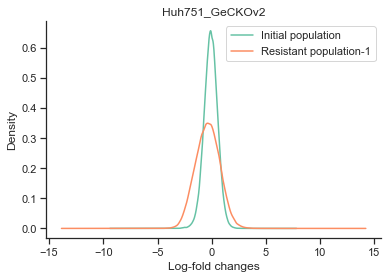

In [10]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[-2:])
pDNA_lfc = calculate_lfc(lognorms,target_cols)
#Plot population distributions of log-fold changes 
lfc_dist_plot(pDNA_lfc, filename = 'Huh751_GeCKOv2')

### Control Distributions

../Figures/Huh751_GeCKOv2_controldist.png


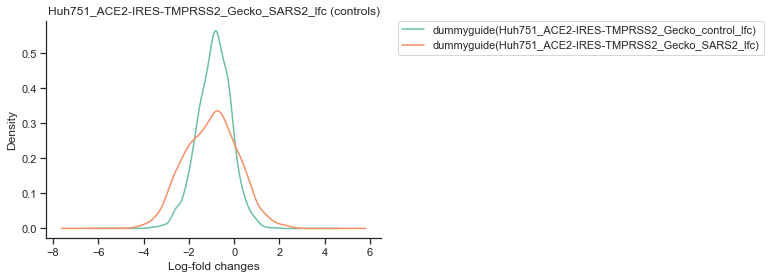

In [11]:
control_dist_plot(pDNA_lfc, control_name=['dummyguide'], filename = 'Huh751_GeCKOv2')

### ROC-AUC

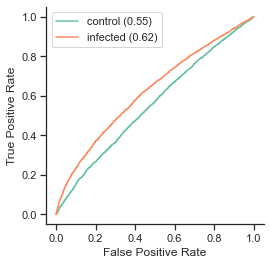

In [12]:
#Plot ROC-AUC
lfc_pair = pair_cols(pDNA_lfc)[1][0]
control_col = lfc_pair[0]
res_col = lfc_pair[1]
df_ann = merge_gene_sets(pDNA_lfc)
#print(df_ann)
roc_auc_ctrl, roc_df_ctrl = get_roc_auc(df_ann, control_col)
roc_auc_res, roc_df_res = get_roc_auc(df_ann, res_col)
fig, ax = plt.subplots()
g = plt.plot(roc_df_ctrl.False_Positive_Rate, roc_df_ctrl.True_Positive_Rate, label = 'control ('+str(np.round(roc_auc_ctrl,2))+')')
g = plt.plot(roc_df_res.False_Positive_Rate, roc_df_res.True_Positive_Rate, label = 'infected ('+str(np.round(roc_auc_res,2))+')')
t = plt.xlabel('False Positive Rate')
t = plt.ylabel('True Positive Rate')
sns.despine()
ax.set_aspect('equal')
t = plt.legend()
fig.savefig('../Figures/Puschnik_ROC-AUC.png', dpi=1000)


## Gene-level analysis

### Residual z-scores

In [13]:
#Calculate z-scores of lfc residuals
lfc_df = pDNA_lfc.copy().drop(['Gene Symbol'], axis = 1)
lfc_df = lfc_df.dropna()

guide_residuals_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_df)

guide_mapping = pDNA_lfc[['Guide', 'Gene Symbol']]

gene_residuals = anchors.get_gene_residuals(guide_residuals_lfcs, guide_mapping)
gene_residuals

                                   modified  \
0  Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc   

                                  unperturbed  
0  Huh751_ACE2-IRES-TMPRSS2_Gecko_control_lfc  


,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,A1BG,6,-0.388630,-0.078396,-0.051673,0.958789,0.998631
1,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,A1CF,6,-0.570074,-0.198043,-0.208600,0.834761,0.994389
2,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,A2M,6,-0.173488,0.009172,0.276440,0.782210,0.987715
3,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,A2ML1,6,0.990566,0.088141,3.266771,0.001088,0.232647
4,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,A3GALT2,6,0.670618,0.355756,1.596300,0.110422,0.848085
...,...,...,...,...,...,...,...,...
21206,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,hsa-mir-95,4,0.116153,0.560040,-0.417921,0.676005,0.978077
21207,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,hsa-mir-96,4,0.389002,0.098076,1.282439,0.199689,0.897070
21208,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,hsa-mir-98,4,-0.594006,0.133466,-1.001658,0.316509,0.924095
21209,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,hsa-mir-99a,4,0.495609,0.713639,0.070137,0.944085,0.998552


In [14]:
gene_residual_sheet= format_gene_residuals(gene_residuals, guide_min = 5, guide_max = 7)
guide_residual_sheet = pd.merge(guide_mapping, guide_residuals_lfcs, on = 'Guide', how = 'outer')
guide_residual_sheet

['Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc']


,Guide,Gene Symbol,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,A1BG.1-A,A1BG,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,-0.196831,-0.221334,Huh751_ACE2-IRES-TMPRSS2_Gecko_control_lfc,-0.615622,-0.122244
1,A1BG.2-A,A1BG,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,1.220076,1.371961,Huh751_ACE2-IRES-TMPRSS2_Gecko_control_lfc,0.357418,-0.550966
2,A1BG.3-A,A1BG,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,-1.267408,-1.425186,Huh751_ACE2-IRES-TMPRSS2_Gecko_control_lfc,-1.711406,-0.146452
3,A1CF.1-A,A1CF,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,0.201145,0.226185,Huh751_ACE2-IRES-TMPRSS2_Gecko_control_lfc,-0.329681,-0.229973
4,A1CF.2-A,A1CF,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,-1.132375,-1.273342,Huh751_ACE2-IRES-TMPRSS2_Gecko_control_lfc,-2.195854,-0.746578
...,...,...,...,...,...,...,...,...
123196,dummyguide.995-B,dummyguide_253,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,-0.083471,-0.093862,Huh751_ACE2-IRES-TMPRSS2_Gecko_control_lfc,-1.643576,-1.234482
123197,dummyguide.996-B,dummyguide_181,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,0.451410,0.507606,Huh751_ACE2-IRES-TMPRSS2_Gecko_control_lfc,-0.838912,-0.968719
123198,dummyguide.997-B,dummyguide_63,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,-0.094189,-0.105915,Huh751_ACE2-IRES-TMPRSS2_Gecko_control_lfc,-0.034530,0.334181
123199,dummyguide.998-B,dummyguide_154,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,-0.268922,-0.302400,Huh751_ACE2-IRES-TMPRSS2_Gecko_control_lfc,-1.426278,-0.838359


In [15]:
with pd.ExcelWriter('../Data/Processed/GEO_submission/Huh751_GeCKOv2_Puschnik.xlsx') as writer:  
    gene_residual_sheet.to_excel(writer, sheet_name='Huh751_GeCKOv2_avg_zscore', index =False)
    reads.to_excel(writer, sheet_name='Huh751_GeCKOv2_genomewide_reads', index =False)
    guide_mapping.to_excel(writer, sheet_name='Huh751_GeCKOv2_guide_mapping', index =False)

In [16]:
with pd.ExcelWriter('../Data/Processed/Individual_screens/Huh751_GeCKOv2_Puschnik_v2.xlsx') as writer:   
    gene_residuals.to_excel(writer, sheet_name='gene-level_zscore', index =False)
    guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)